## Importing Necessary Libraries

In [1]:
# !pip install evaluate
# !pip install seaborn
# !pip install tensorflow
# !pip install rouge
# !pip install transformers
# !pip install scipy
# !pip install sklearn
# !pip install sentence_transformers
# !pip install nltk
# !pip install sentencepiece
# !pip install accelerate -U
# !pip install tf-keras

In [1]:
import os                      # For interacting with the operating system
import nltk                    # The Natural Language Toolkit
import time                    # For tracking time, e.g., measuring how long operations take
import torch                   # The main PyTorch library for tensor operations and neural networks
import psutil                  # For accessing system details and process utilities
import random                  # For generating random numbers, shuffling data
import logging                 # For logging events for debugging or progress output
import warnings                # To control warning messages displayed by Python
import evaluate                # A library for ev|aluation metrics, provided by Hugging Face
import numpy as np             # Fundamental package for scientific computing with Python
import pandas as pd            # For data manipulation and analysis
import seaborn as sns          # For making attractive and informative statistical graphics
from tqdm import tqdm          # Provides a progress bar for loops
from rouge import Rouge        # For calculating Rouge scores, typically used in text summarization
from torch import tensor       # Directly import tensor for convenience from PyTorch
import matplotlib.pyplot as plt # For creating static, interactive, and animated visualizations in Python
from transformers import EvalPrediction  # For handling predictions and labels during model evaluation
from torch.utils.data import DataLoader  # For loading data in batches during model training
from datasets import Dataset, DatasetDict  # From Hugging Face 'datasets', for managing large datasets
from scipy.spatial.distance import cosine  # For calculating cosine distance between vectors
from torch.nn.utils.rnn import pad_sequence  # For padding sequences to a maximum length in a batch of sequences
from scipy.optimize import linear_sum_assignment 
from sklearn.model_selection import train_test_split  # For splitting arrays or matrices into random train and test subsets
from sentence_transformers import SentenceTransformer  # For using pre-trained models for embedding sentences to vectors
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction  # For evaluating text translation quality using BLEU score
from transformers import TrainingArguments, TrainerControl, TrainerCallback, Trainer, TrainerState, GPT2Tokenizer, GPT2LMHeadModel, TextGenerationPipeline, DataCollatorWithPadding, AutoTokenizer, AutoModel
# Various classes from Hugging Face 'transformers' to train and evaluate transformer models, manage training parameters

plt.rcParams['figure.dpi'] = 300  # Increase the resolution of all plots for better clarity
warnings.filterwarnings("ignore")  # Ignore warnings to clean up output, not recommended in production
logging.disable(logging.WARNING)  # Turn off logging warnings to make the output cleaner
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

c:\Users\User\anaconda3\envs\FINAL\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
'export' is not recognized as an internal or external command,
operable program or batch file.


## Loading the Cleaned Data

In [2]:
# Reading the data into a DataFrame
# 'pd.read_csv' reads the CSV file from the specified path and loads it into a DataFrame named 'Nvidia_data'.
# This allows for easy data manipulation and analysis using pandas, a powerful data manipulation library in Python. 'Nvidia_cleaned_big_quoted.csv' is our customised dataset.
Nvidia_data = pd.read_csv('Nvidia_cleaned_big_quoted.csv')

# Displaying the first few rows of the data to ensure it's loaded correctly
# 'print' is used to output a string as a header for the displayed data.
print("First few rows of the data:")
# 'Nvidia_data.head(5)' returns the first five rows of the DataFrame 'Nvidia_data'.
# 'display()' is a Jupyter Notebook function that renders DataFrames as formatted HTML tables.
# It is used here instead of 'print()' for a more readable output of DataFrame content.
display(Nvidia_data.head(5))

First few rows of the data:


,question,answer
0,what is hybridizer?,hybridizer is a compiler for programming gpus ...
1,how does hybridizer generate optimized code?,hybridizer generates optimized code using deco...
2,what are some parallelization patterns mention...,the text mentions parallelization patterns lik...
3,how can you benefit from accelerators without ...,use patterns like parallel.for or cuda-like di...
4,what is an example of using hybridizer?,using parallel.for with a lambda to utilize th...


## Data Preparation

In [3]:
# Ensure consistent columns and drop missing values
# This line ensures the data only contains 'question' and 'answer' columns and removes any rows with missing values.
# 'dropna()' is used to ensure the model receives complete data pairs for training.
Nvidia_data = Nvidia_data[["question", "answer"]].dropna().reset_index(drop=True)

# Split the data into training, validation, and test sets
# Here we split the data into separate sets for training, validation, and testing using a common 70-20-10 split ratio.
# 'random_state' ensures reproducibility of the splits.
train_data, temp_set = train_test_split(Nvidia_data, test_size=0.3, random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=1/3, random_state=42)

# Create Hugging Face Dataset objects from Pandas DataFrames
# Converts the Pandas DataFrames into Hugging Face's Dataset objects which are optimized for NLP tasks and compatible with their transformers library.
train_dataset = Dataset.from_pandas(train_data.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_set.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_set.reset_index(drop=True))

# Combine the datasets into a DatasetDict
# DatasetDict is a dictionary-like container that holds datasets for different phases of training and evaluation.
dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

# Initialize tokenizer
# Loads a pre-trained GPT-2 tokenizer and adds special tokens necessary for GPT-2 to function properly.
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]', 'eos_token': '[EOS]'})

def tokenizer_for_gpt(examples):
    # Concatenate question and answer for training with a separator to help the model distinguish parts
    # This function preprocesses the text by concatenating the question and answer, preparing it for tokenization.
    # It helps the model to understand where the question ends and the answer begins.
    concatenated_examples = ["question: " + q + " answer: " + a for q, a in zip(examples['question'], examples['answer'])]
    model_inputs = tokenizer(concatenated_examples, max_length=155, truncation=True, padding="max_length", return_tensors="pt")
    # Labels are duplicated from inputs as GPT-2 uses a language modeling loss, predicting each token in the sequence.
    model_inputs['labels'] = model_inputs['input_ids'].clone()
    return model_inputs

# Apply the function to tokenize the entire dataset dictionary
# This step applies the preprocessing function across all datasets (training, validation, test), effectively tokenizing all text data.
tokenized_dataset = dataset_dict.map(tokenizer_for_gpt, batched=True, remove_columns=dataset_dict['train'].column_names)

# Display the tokenized dataset to check if everything is as expected
display(tokenized_dataset)

Map: 100%|██████████| 696/696 [00:00<00:00, 3179.27 examples/s]


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4869
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1391
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 696
    })
})

In [4]:
# Random seed for reproducibility
# Setting a fixed seed ensures that the random operations can be replicated exactly the same way each time the code runs.
random.seed(42)

# Get the number of rows for each dataset
# These lines count the total number of entries in each subset (train, validation, test) of our dataset.
train_rows = len(tokenized_dataset["train"])
val_rows = len(tokenized_dataset["validation"])
test_rows = len(tokenized_dataset["test"])

# Calculate the subset size based on the fraction
# Here we're calculating the size of each subset. For training, we use the entire dataset, while for validation and test, we only use 1.5% of the data.
train_subset_size = int(train_rows * 0.25)  # Using 25% of the training data
val_subset_size = int(val_rows * 0.25)  # Using 25% of the validation data
test_subset_size = int(test_rows * 0.25)  # Using 25% of the test data

# Create the subsets by selecting random indices
# These lines generate random indices to select a subset of data. This randomness introduces variety in the subsets used for model training and evaluation.
train_subset_indices = random.sample(range(train_rows), train_subset_size)
val_subset_indices = random.sample(range(val_rows), val_subset_size)
test_subset_indices = random.sample(range(test_rows), test_subset_size)

# Use the indices to create the subsets
# These lines actually create the subsets by selecting the entries corresponding to the random indices we generated. This forms the actual data slices used for model operations.
train_subset = tokenized_dataset["train"].select(train_subset_indices)
val_subset = tokenized_dataset["validation"].select(val_subset_indices)
test_subset = tokenized_dataset["test"].select(test_subset_indices)
test_subset_w_qa = dataset_dict["test"].select(test_subset_indices)

# Combine the subsets into a DatasetDict
# We consolidate these subsets back into a DatasetDict, which is a convenient format for handling train, validation, and test sets within Hugging Face's ecosystem.
subset_dict = DatasetDict({
    'train': train_subset,
    'validation': val_subset,
    'test': test_subset,
    'test_w_qa' : test_subset_w_qa
})

# Display the subsetted DatasetDict
# This display the new dataset dictionary with the subsetted data, ready for use in training or evaluation.
subset_dict

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1217
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 347
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 174
    })
    test_w_qa: Dataset({
        features: ['question', 'answer'],
        num_rows: 174
    })
})

## Pre-Training Setup

In [5]:
nltk.download('punkt')

# Load the pre-trained model and tokenizer for SMS
sms_model_name = 'sentence-transformers/all-mpnet-base-v2'
sms_tokenizer = AutoTokenizer.from_pretrained(sms_model_name)
sms_model = AutoModel.from_pretrained(sms_model_name)

def get_word_embeddings(sentence):
    """
    Get the embeddings for each word in a sentence using the specified tokenizer and model.
    """
    tokens = nltk.word_tokenize(sentence)
    if not tokens:
        return np.empty((0, 768))  # Return empty array if no tokens
    inputs = sms_tokenizer(tokens, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = sms_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

def sentence_movers_similarity(sentence1, sentence2):
    """
    Calculate the Sentence Mover's Similarity (SMS) between two sentences.
    """
    # Get word embeddings for both sentences
    emb1 = get_word_embeddings(sentence1)
    emb2 = get_word_embeddings(sentence2)
    # Ensure embeddings are not empty
    if emb1.size == 0 or emb2.size == 0:
        return 0.0
    # Compute the cost matrix
    cost_matrix = np.linalg.norm(emb1[:, np.newaxis] - emb2[np.newaxis, :], axis=2)
    # Solve the linear sum assignment problem (Earth Mover's Distance)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    total_cost = cost_matrix[row_ind, col_ind].sum()
    # Normalize total cost by the maximum possible cost
    max_cost = np.max(cost_matrix)
    normalized_cost = total_cost / (max_cost * max(len(emb1), len(emb2)))
    # Convert distance to similarity score
    similarity = max(0.0, 1 - normalized_cost)
    return similarity

# This function computes precision, recall, and F1 scores by treating labels and predictions as sets of tokens.
def precision_recall_fscore_support(labels, predictions):
    # Convert label and prediction strings into lists of tokens.
    labels_tokens = [token.split() for token in labels]
    predictions_tokens = [token.split() for token in predictions]
    # Convert lists of tokens into sets to facilitate easy calculation of precision and recall.
    labels_set = [set(tokens) for tokens in labels_tokens]
    predictions_set = [set(tokens) for tokens in predictions_tokens]
    # Calculate precision and recall using set intersections.
    precision = sum([len(pred_set & label_set) / len(pred_set) for pred_set, label_set in zip(predictions_set, labels_set)]) / len(predictions_set)
    recall = sum([len(pred_set & label_set) / len(label_set) for pred_set, label_set in zip(predictions_set, labels_set)]) / len(labels_set)
    # Calculate F1 score as the harmonic mean of precision and recall.
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
    return f1, precision, recall

# This function processes evaluation data to compute metrics.
def compute_metrics(eval_pred):
    # Measure start time to calculate latency later.
    start_time = time.time()
    predictions, labels = eval_pred.predictions, eval_pred.label_ids
    # Convert model logits to token IDs if necessary.
    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)
    # Decode token IDs back to strings.
    decoded_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    # Remove the 'question' part from the decoded texts to focus only on the answers.
    decoded_predictions = [pred.split("answer:")[1].strip() if "answer:" in pred else pred for pred in decoded_predictions]
    decoded_labels = [label.split("answer:")[1].strip() if "answer:" in label else label for label in decoded_labels]
    # Compute metrics using various methods.
    f1, precision, recall = precision_recall_fscore_support(decoded_labels, decoded_predictions)
    rouge = Rouge()
    rouge_scores = rouge.get_scores(decoded_predictions, decoded_labels, avg=True)
    reference_texts = [[label.split()] for label in decoded_labels]
    candidate_texts = [pred.split() for pred in decoded_predictions]
    bleu_score = np.mean([sentence_bleu(ref, cand, smoothing_function=SmoothingFunction().method1) for ref, cand in zip(reference_texts, candidate_texts)])
    # Generate embeddings and compute cosine similarity.
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings_pred = model.encode(decoded_predictions)
    embeddings_label = model.encode(decoded_labels)
    cosine_similarities = [1 - cosine(embeddings_pred[i], embeddings_label[i]) for i in range(len(decoded_predictions))]
    avg_cosine_similarity = sum(cosine_similarities) / len(cosine_similarities)
    # Calculate Sentence Mover's Similarity (SMS)
    sms_scores = [sentence_movers_similarity(decoded_labels[i], decoded_predictions[i]) for i in tqdm(range(len(decoded_predictions)), desc="Calculating SMS")]
    avg_sms = sum(sms_scores) / len(sms_scores)
     # Clean up to save memory
    del decoded_predictions, decoded_labels, embeddings_pred, embeddings_label, rouge, model
    torch.cuda.empty_cache()
    # Calculate latency and memory usage.
    latency = time.time() - start_time
    process = psutil.Process()
    memory_usage = process.memory_info().rss / (1024 ** 2)
    # Return all calculated metrics.
    metrics = {"precision": precision, "recall": recall, "f1": f1,"rouge-1": rouge_scores['rouge-1']['f'], "rouge-2": rouge_scores['rouge-2']['f'],
            "rouge-l": rouge_scores['rouge-l']['f'],"bleu": bleu_score, "cosine_similarity": avg_cosine_similarity, 
            "sentence_movers_similarity": avg_sms, "latency": latency, "memory_usage": memory_usage}
    # Save to a CSV file
    df = pd.DataFrame([metrics])
    df.to_csv('metrics_history_GPT2_25.csv', mode='a',header=not os.path.exists('metrics_history_GPT2_25.csv'))
    return metrics

# Callbacks for monitoring and adjusting training behavior.

# Tracks losses during training and validation.
class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
    def on_log(self, args, state, control, logs=None, **kwargs):
        # Append training loss to the tracking list.
        if 'loss' in logs:
            self.train_loss.append((state.global_step, logs['loss']))
    def on_evaluate(self, args, state, control, metrics, **kwargs):
        # Append validation loss to the tracking list.
        if 'eval_loss' in metrics:
            self.val_loss.append((state.global_step, metrics['eval_loss']))

# Frees up GPU memory after each epoch to prevent out-of-memory errors.
class MemoryCleanupCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        logging.info("Clearing GPU memory at the end of the epoch")
        torch.cuda.empty_cache()

# Placeholder for generation settings adjustments; requires specific implementation details.
class GenerationControlCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, model=None, **kwargs):
        torch.cuda.empty_cache()
        model.config.update({"max_length": 50, "num_return_sequences": 1, "num_beams": 5, "no_repeat_ngram_size": 2, "temperature": 0.7,
                             "top_p": 0.85, "top_k": 40, "early_stopping": True})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Training Arguments

In [9]:
# Initialize model
# Load a pre-trained GPT2LMHeadModel from the 'openai-community/gpt2' checkpoint.
model = GPT2LMHeadModel.from_pretrained('distilgpt2')
# Resize the token embeddings of the model to match the number of tokens in the tokenizer.
# This is necessary if the tokenizer has a different size than the default settings of the pre-trained model.
model.resize_token_embeddings(len(tokenizer))

data_collator=DataCollatorWithPadding(tokenizer=tokenizer)

# Setup training arguments
# Configure the training process with specific parameters.
training_args = TrainingArguments(
    output_dir='./results',  # Directory where the outputs (model checkpoints) will be saved.
    num_train_epochs=5,  # Total number of training epochs to perform.
    per_device_train_batch_size=8,  # Batch size for training.
    per_device_eval_batch_size=4,  # Batch size for evaluation.
    warmup_steps=500,  # Number of steps to perform learning rate warmup.
    weight_decay=0.01,  # Weight decay to apply.
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch.
    save_strategy="epoch",  # Save the model at the end of each epoch.
    gradient_accumulation_steps=2,
    eval_accumulation_steps = 2,
    gradient_checkpointing = True,
)

# Initialize callbacks that enhance the training loop functionality.

# Initialize the generation control callback, which may adjust generation settings during evaluation.
generation_callback = GenerationControlCallback()

# Create a callback to track and log the loss during training and validation.
loss_callback = LossTrackingCallback()

# Add a custom callback to clean up GPU memory after each epoch to prevent out-of-memory errors.
memory_callback = MemoryCleanupCallback()

# Initialize Trainer
# Create a Trainer instance to manage the training process.
trainer = Trainer(
    model=model,  # The model to train.
    args=training_args,  # The training arguments.
    train_dataset=subset_dict['train'],  # Training dataset.
    eval_dataset=subset_dict['validation'],  # Validation dataset.
    callbacks=[generation_callback, loss_callback, memory_callback],  # List of callbacks to use during training.
    compute_metrics=compute_metrics,  # Function to compute metrics during evaluation.
    data_collator=data_collator, 
)

## Fine Tuning

In [10]:
# Start the training process using the Trainer instance configured earlier.
trainer.train()

# Save the fine-tuned model
# After training, the fine-tuned model is saved to a specified directory. This allows you to reload the model later,
# either for further training, evaluation, or to use it for predictions. The path provided ('./Nvidia_distilgpt2_finetuned')
# specifies the directory where the model's files are stored.
trainer.save_model('./Nvidia_distilgpt2_25_finetuned')

# Save the tokenizer associated with the model
# It's crucial to save the tokenizer along with the model because the tokenizer contains the mapping from words
# to token IDs and various other settings that must be the same when you load the model for further use.
# This ensures consistency between the training and inference environments, which helps in maintaining the model's performance.
tokenizer.save_pretrained('./Nvidia_distilgpt2_25_finetuned')

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Rouge-1,Rouge-2,Rouge-l,Bleu,Cosine Similarity,Sentence Movers Similarity,Latency,Memory Usage
0,No log,1.512040,0.198213,0.194226,0.196199,0.205512,0.042125,0.185561,0.028885,0.479609,0.693885,227.172239,12696.683594
2,No log,0.719729,0.446392,0.386697,0.414406,0.438779,0.195790,0.420654,0.128060,0.733016,0.595755,194.958718,12753.542969
4,No log,0.675484,0.446265,0.389320,0.415852,0.437088,0.200443,0.421080,0.130887,0.734161,0.597134,190.768847,12827.082031


Calculating SMS: 100%|██████████| 347/347 [03:07<00:00,  1.85it/s]


('./Nvidia_distilgpt2_25_finetuned/tokenizer_config.json',
 './Nvidia_distilgpt2_25_finetuned/special_tokens_map.json',
 './Nvidia_distilgpt2_25_finetuned/vocab.json',
 './Nvidia_distilgpt2_25_finetuned/merges.txt',
 './Nvidia_distilgpt2_25_finetuned/added_tokens.json')

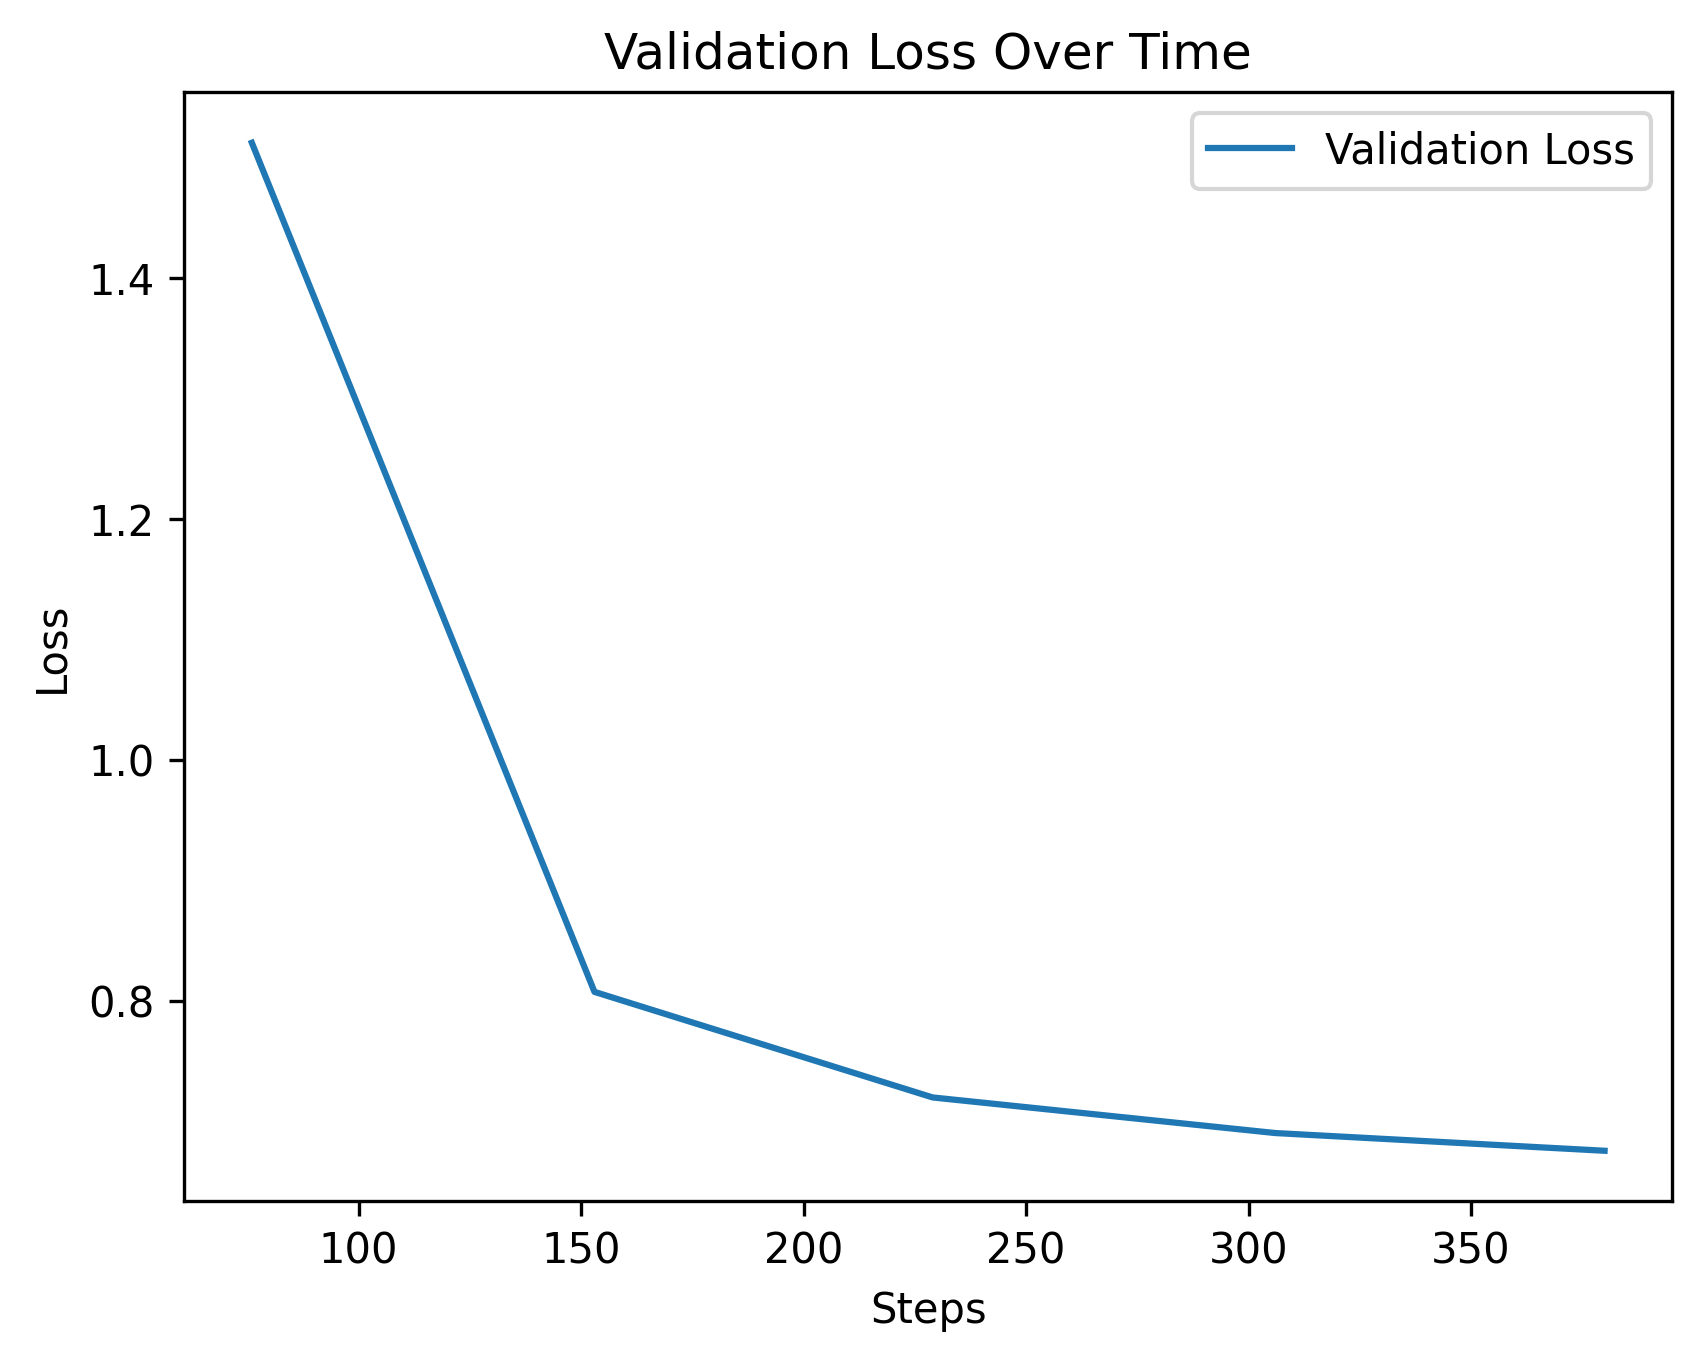

In [12]:
# Plot the training and validation loss
# Extract the steps and loss values from the loss tracking callback. `train_loss` and `val_loss` are lists of tuples
# where each tuple contains the step number and the loss value at that step. Unpacking these lists into `train_steps` 
# and `train_losses` (for training data) and `val_steps` and `val_losses` (for validation data) allows us to easily plot them.
# train_steps, train_losses = zip(*loss_callback.train_loss)
val_steps, val_losses = zip(*loss_callback.val_loss)

# Create a line plot for training and validation losses.
# Here, we use matplotlib to plot these values. `train_steps` and `train_losses` are used to plot the training loss over time,
# similarly for `val_steps` and `val_losses` for the validation loss. This visualization helps in understanding how the loss changes
# with respect to the number of training steps and can be crucial for diagnosing issues with model training such as overfitting or not
# converging.
# plt.plot(train_steps, train_losses, label="Training Loss")
plt.plot(val_steps, val_losses, label="Validation Loss")

# Labeling the axes and adding a title and legend.
# Proper labels and a title improve the readability of the plot, making it clear what each axis represents and what the plot shows.
# The legend distinguishes between the two lines, identifying which one is for training and which is for validation.
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Validation Loss Over Time")
plt.legend()

# Display the plot
# This function call renders the plot. Without this, in some environments, the plot might not be shown.
plt.show()

## Model Evaluation

In [13]:
# Load the trained model and tokenizer
# We load the model and tokenizer from the specified directory where they were saved after training. 
# This ensures that the same model configuration and tokenizer settings are used during testing.
model = GPT2LMHeadModel.from_pretrained('./Nvidia_distilgpt2_25_finetuned')
tokenizer = GPT2Tokenizer.from_pretrained('./Nvidia_distilgpt2_25_finetuned')

# Set the device to CUDA if available, otherwise use CPU
# This line checks if CUDA is available for PyTorch and sets the device accordingly. Using CUDA will allow the model to run
# on a GPU, greatly increasing computation speed. If unavailable, it defaults to CPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Move the model to the appropriate device.

# Setup testing arguments
# Although named `training_args`, these settings are also applicable to testing. It configures parameters like the output directory, 
# batch sizes for training and evaluation, number of training epochs (not applicable here but required for initialization), warmup steps, 
# weight decay, and logging details. `evaluation_strategy` and `save_strategy` control how often the model is evaluated and saved during training.
training_args = TrainingArguments(output_dir='./results', num_train_epochs=5, per_device_train_batch_size=8, per_device_eval_batch_size=4,
                                  warmup_steps=500, weight_decay=0.01, logging_dir='./logs', evaluation_strategy="epoch", save_strategy="epoch",
                                 gradient_accumulation_steps=2, eval_accumulation_steps = 2, gradient_checkpointing = True)

# Initialize the callback
# `GenerationControlCallback` adjusts the settings used during the generation of text. This might be necessary to fine-tune 
# how the model generates text under specific testing conditions.
generation_callback = GenerationControlCallback()

# Create the loss tracking callback
# `LossTrackingCallback` tracks the loss during training or evaluation. This is useful for later analysis to see how well the model was performing.
loss_callback = LossTrackingCallback()

# Add the custom memory cleanup callback
# `MemoryCleanupCallback` is used to clear the GPU memory cache after each epoch or evaluation, preventing out of memory errors
# during prolonged training or evaluation sessions.
memory_callback = MemoryCleanupCallback()

# Initialize Trainer
# The `Trainer` object is used to manage training and evaluation. It is setup with the model, the arguments, the callbacks, and the method 
# to compute metrics during evaluation.
trainer = Trainer(model=model, args=training_args, callbacks=[generation_callback, loss_callback, memory_callback], compute_metrics=compute_metrics,)

# Ensure the test data is available and appropriately prepared
# This line assumes you have previously split your data and prepared a test dataset, which should be correctly formatted and ready.
test_dataset = tokenized_dataset['test']  # make sure this is correctly loaded or prepared

# Evaluate the model on the test dataset
# The `evaluate` method is called on the `test_dataset` to compute the performance metrics based on the `compute_metrics` function.
test_results = trainer.evaluate(test_dataset)

# Convert test results to a DataFrame
# The results from `evaluate` are converted into a pandas DataFrame for better readability and analysis, making it easier to view and understand.
df_results = pd.DataFrame([test_results])

# Display the DataFrame
# The final results are displayed. This is useful for quick inspection and to ensure the metrics are as expected.
display(df_results)

Calculating SMS: 100%|██████████| 696/696 [06:35<00:00,  1.76it/s]


,eval_loss,eval_precision,eval_recall,eval_f1,eval_rouge-1,eval_rouge-2,eval_rouge-l,eval_bleu,eval_cosine_similarity,eval_sentence_movers_similarity,eval_latency,eval_memory_usage,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.665981,0.448373,0.393908,0.41938,0.435078,0.197727,0.416008,0.128036,0.742304,0.602619,400.371537,23378.066406,524.3676,1.327,0.332


In [14]:
df_results.to_csv("GPT2_25_Test_Results.csv")

## Randomly Predicting Answer using the Trained Model

In [15]:
def generate_answer(question, model, tokenizer, device):
    # Create a text-generation pipeline that prepares the model for generating text based on input prompts.
    generator = TextGenerationPipeline(model=model, tokenizer=tokenizer, device=device)
    
    # Format the input text with a predefined structure to guide the model on how to respond.
    input_text = f"question: {question} answer:"
    # Use the text-generation pipeline to generate a response based on the input text, configuring parameters
    # to control how the text is generated.
    generated_texts = generator(input_text, max_length=40, num_return_sequences=1, num_beams=5,
                                 no_repeat_ngram_size=2, temperature=0.7, top_p=0.85, top_k=40,
                                 early_stopping=True, prefix=input_text)
    
    # Extract the actual generated text from the model's output, focusing on the part after "answer:".
    answer = generated_texts[0]['generated_text'].split("answer:")[-1].strip()
    return answer

# Load the pre-trained GPT-2 model and tokenizer. This model has been fine-tuned and saved locally.
model = GPT2LMHeadModel.from_pretrained('./Nvidia_distilgpt2_25_finetuned')
tokenizer = GPT2Tokenizer.from_pretrained('./Nvidia_distilgpt2_25_finetuned')

# Determine if a CUDA capable GPU is available, and set the model to run on the appropriate device for optimal performance.
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)  # Move model to the specified device (GPU or CPU) to ensure computational efficiency.

# Generate a random selection of indices to pick questions randomly from the test set, enhancing the variety of test samples.
random_indices = random.sample(range(len(dataset_dict['test'])), 5)
questions = [dataset_dict['test']['question'][i] for i in random_indices]
actual_answers = [dataset_dict['test']['answer'][i] for i in random_indices]

# Loop through each randomly selected question, generate an answer using the model, and print the question, actual answer, and model's generated answer.
for question, actual_answer in zip(questions, actual_answers):
    predicted_answer = generate_answer(question, model, tokenizer, device)
    print("Question:", question)
    print("Actual Answer:", actual_answer)
    print("Predicted Answer:", predicted_answer)
    print("\n---\n")

Question: what role does stream capture play in the creation of cuda graphs?
Actual Answer: stream capture captures cuda operations, compiles them into a graph for efficient reuses.
Predicted Answer: stream captures data from multiple streams, providing a unified view of the graph and providing an accurate view.

---

Question: why is parallel programming considered important for accelerating applications?
Actual Answer: parallel programming enhances application speed by distributing tasks across multiple processor cores or gpus.
Predicted Answer: parallel programming is used to accelerate applications faster and faster than parallel code, improving performance and improving application performance.

---

Question: what type of neural network did the researchers use in their study?
Actual Answer: the researchers used a convolutional neural network trained on the imagenet dataset.
Predicted Answer: researchers used a deep learning algorithm to train neural networks to identify patterns 

In [8]:
import time

# Function to generate an answer for a given question using the model
def generate_answer(question, model, tokenizer, device):
    # Start the timer for this question
    start_time = time.time()
    
    # Create a text-generation pipeline
    generator = TextGenerationPipeline(model=model, tokenizer=tokenizer, device=device)
    
    # Format the input text
    input_text = f"question: {question} answer:"
    
    # Generate a response using the configured parameters
    generated_texts = generator(input_text, max_length=40, num_return_sequences=1, num_beams=5,
                                no_repeat_ngram_size=2, temperature=0.7, top_p=0.85, top_k=40,
                                early_stopping=True)
    
    # Extract the generated text
    answer = generated_texts[0]['generated_text'].split("answer:")[-1].strip()
    
    # End the timer for this question
    end_time = time.time()
    
    # Calculate inference time
    inference_time = end_time - start_time
    
    return answer, inference_time

# Load the model and tokenizer
model = GPT2LMHeadModel.from_pretrained('./Nvidia_distilgpt2_25_finetuned')
tokenizer = GPT2Tokenizer.from_pretrained('./Nvidia_distilgpt2_25_finetuned')

# Check for GPU availability and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Sample questions from the dataset
random_indices = random.sample(range(len(dataset_dict['test'])), 5)
questions = [dataset_dict['test']['question'][i] for i in random_indices]
actual_answers = [dataset_dict['test']['answer'][i] for i in random_indices]

# Start timing for the batch of questions
batch_start_time = time.time()

# Process each question and measure the time taken
total_inference_time = 0
for question, actual_answer in zip(questions, actual_answers):
    predicted_answer, inference_time = generate_answer(question, model, tokenizer, device)
    total_inference_time += inference_time
    
    # Output the results for each question
    print("Question:", question)
    print("Actual Answer:", actual_answer)
    print("Predicted Answer:", predicted_answer)
    print(f"Inference Time: {inference_time:.2f} seconds")
    print("\n---\n")

# End timing for the batch
batch_end_time = time.time()

# Calculate and print the average time taken per question
average_time = (batch_end_time - batch_start_time) / len(questions)
print("Average Inference Time for 5 questions: {:.2f} seconds".format(average_time))


Question: what is the potential use case of the growing allocator in data analytics?
Actual Answer: the growing allocator enhances memory utilization in data analytics, especially for data-dependent join operations.
Predicted Answer: the growth of ai is due in part to the large number of threads in the gpu.
Inference Time: 0.30 seconds

---

Question: what is the significance of the graalvm community edition?
Actual Answer: the graalvm community edition is a free, open-source platform for developers.
Predicted Answer: graallvm is a toolkit for improving gpu-accelerated computing, improving performance, and enhancing performance.
Inference Time: 0.20 seconds

---

Question: how can you achieve load balancing among threads in a gpu application?
Actual Answer: distribute tasks evenly among threads, using techniques like dynamic parallelism and workload partitioning for full utilization.
Predicted Answer: use the 'load balancing' option to load cpu-accelerated applications into a single th

# Accuracy for Human Evaluation 

In [6]:
import csv
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextGenerationPipeline

def generate_answer(question, model, tokenizer, device):
    # Create a text-generation pipeline.
    generator = TextGenerationPipeline(model=model, tokenizer=tokenizer, device=device)
    
    # Format the input text.
    input_text = f"question: {question} answer:"
    
    # Generate the response.
    generated_texts = generator(input_text, max_length=40, num_return_sequences=1, num_beams=5,
                                no_repeat_ngram_size=2, temperature=0.7, top_p=0.85, top_k=40,
                                early_stopping=True, prefix=input_text)
    
    # Extract the answer.
    answer = generated_texts[0]['generated_text'].split("answer:")[-1].strip()
    return answer

# Load the model and tokenizer.
model = GPT2LMHeadModel.from_pretrained('./Nvidia_distilgpt2_25_finetuned')
tokenizer = GPT2Tokenizer.from_pretrained('./Nvidia_distilgpt2_25_finetuned')

# Set the device.
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Open a CSV file to write the results.
with open('predictions.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Question', 'Actual Answer', 'Predicted Answer'])
    
    # Process each question in the test dataset.
    for i in range(len(dataset_dict['test']['question'])):
        question = dataset_dict['test']['question'][i]
        actual_answer = dataset_dict['test']['answer'][i]
        predicted_answer = generate_answer(question, model, tokenizer, device)
        
        # Write to CSV file.
        writer.writerow([question, actual_answer, predicted_answer])

In [7]:
import pandas as pd

# Load the CSV file
file_path = 'prediction_distilgpt2_25.csv'
data = pd.read_csv(file_path)

# Define a function to convert the outcome text to a numeric value
def outcome_to_numeric(outcome):
    outcome = outcome.strip().lower()  # Clean and lower-case the text
    if outcome == 'incorrect':
        return 0
    elif outcome == 'partially correct':
        return 0.5
    elif outcome == 'correct':
        return 1
    else:
        return None

# Apply the function to the 'outcome' column to create 'value_outcome'
data['value_outcome'] = data['outcome'].apply(outcome_to_numeric)

# Calculate the average of the 'value_outcome' column
average_value_outcome = (data['value_outcome'].mean())*100
print("Average of value_outcome:", average_value_outcome, "%")


Average of value_outcome: 5.531609195402299 %
